In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
import os


In [2]:
def load_data_from_directory(base_path, categories, image_size=(64, 64)):
    data, labels = [], []
    for label_index, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        for img_file in os.listdir(category_path):
            try:
                img_path = os.path.join(category_path, img_file)
                img = imread(img_path)
                img_resized = resize(img, image_size)
                data.append(img_resized.flatten())
                labels.append(label_index)
            except:
                print(f"Failed to load: {img_path}")
    return np.array(data), np.array(labels)


In [3]:
def get_models():
    return {
        "SVM": make_pipeline(StandardScaler(), SVC(probability=True)),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }


In [4]:
dataset_path = 'dataset'
categories = os.listdir(os.path.join(dataset_path, 'train'))
print("Categories:", categories)

x_train, y_train = load_data_from_directory(os.path.join(dataset_path, 'train'), categories)
x_valid, y_valid = load_data_from_directory(os.path.join(dataset_path, 'valid'), categories)
x_test, y_test   = load_data_from_directory(os.path.join(dataset_path, 'test'), categories)

print("Train shape:", x_train.shape, "Labels:", y_train.shape)
print("Valid shape:", x_valid.shape, "Labels:", y_valid.shape)
print("Test shape:", x_test.shape, "Labels:", y_test.shape)


Categories: ['Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Bacterial Red disease', 'EUS', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease']
Train shape: (2097, 12288) Labels: (2097,)
Valid shape: (448, 12288) Labels: (448,)
Test shape: (457, 12288) Labels: (457,)


In [5]:
models = get_models()
accuracies = {}

for name, model in models.items():
    print(f"\n🧠 Training {name}...")
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_valid)
    acc = accuracy_score(y_valid, y_val_pred)
    accuracies[name] = acc
    print(f"✅ {name} Validation Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_valid, y_val_pred, target_names=categories))



🧠 Training SVM...
✅ SVM Validation Accuracy: 55.13%
                                   precision    recall  f1-score   support

Bacterial diseases - Aeromoniasis       0.69      0.52      0.60        48
           Bacterial gill disease       0.62      0.79      0.69        87
            Bacterial Red disease       0.40      0.44      0.42        39
                              EUS       0.32      0.18      0.23        45
   Fungal diseases Saprolegniasis       0.69      0.22      0.33        41
                     Healthy Fish       0.55      0.83      0.66       110
               Parasitic diseases       0.44      0.32      0.37        34
Viral diseases White tail disease       0.59      0.39      0.47        44

                         accuracy                           0.55       448
                        macro avg       0.54      0.46      0.47       448
                     weighted avg       0.55      0.55      0.52       448


🧠 Training Random Forest...
✅ Random Forest

C:\Users\kodan\Desktop\fish_disease_classifier\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression Validation Accuracy: 48.21%
                                   precision    recall  f1-score   support

Bacterial diseases - Aeromoniasis       0.53      0.42      0.47        48
           Bacterial gill disease       0.63      0.57      0.60        87
            Bacterial Red disease       0.26      0.33      0.29        39
                              EUS       0.26      0.20      0.23        45
   Fungal diseases Saprolegniasis       0.35      0.41      0.38        41
                     Healthy Fish       0.68      0.74      0.71       110
               Parasitic diseases       0.32      0.32      0.32        34
Viral diseases White tail disease       0.34      0.34      0.34        44

                         accuracy                           0.48       448
                        macro avg       0.42      0.42      0.42       448
                     weighted avg       0.48      0.48      0.48       448


🧠 Training Decision Tree...
✅ Decision Tree Va

C:\Users\kodan\Desktop\fish_disease_classifier\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Validation Accuracy: 62.05%
                                   precision    recall  f1-score   support

Bacterial diseases - Aeromoniasis       0.64      0.48      0.55        48
           Bacterial gill disease       0.66      0.72      0.69        87
            Bacterial Red disease       0.51      0.46      0.49        39
                              EUS       0.39      0.38      0.38        45
   Fungal diseases Saprolegniasis       0.62      0.56      0.59        41
                     Healthy Fish       0.72      0.85      0.78       110
               Parasitic diseases       0.46      0.50      0.48        34
Viral diseases White tail disease       0.69      0.55      0.61        44

                         accuracy                           0.62       448
                        macro avg       0.59      0.56      0.57       448
                     weighted avg       0.62      0.62      0.61       448



In [6]:
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]

print(f"\n🏁 Final Evaluation using best model: {best_model_name}")
y_test_pred = best_model.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(classification_report(y_test, y_test_pred, target_names=categories))



🏁 Final Evaluation using best model: XGBoost
✅ Test Accuracy: 64.99%
                                   precision    recall  f1-score   support

Bacterial diseases - Aeromoniasis       0.64      0.65      0.64        43
           Bacterial gill disease       0.68      0.71      0.70        84
            Bacterial Red disease       0.50      0.56      0.53        43
                              EUS       0.28      0.21      0.24        33
   Fungal diseases Saprolegniasis       0.62      0.62      0.62        40
                     Healthy Fish       0.76      0.86      0.80       127
               Parasitic diseases       0.50      0.40      0.44        43
Viral diseases White tail disease       0.79      0.61      0.69        44

                         accuracy                           0.65       457
                        macro avg       0.60      0.58      0.58       457
                     weighted avg       0.64      0.65      0.64       457



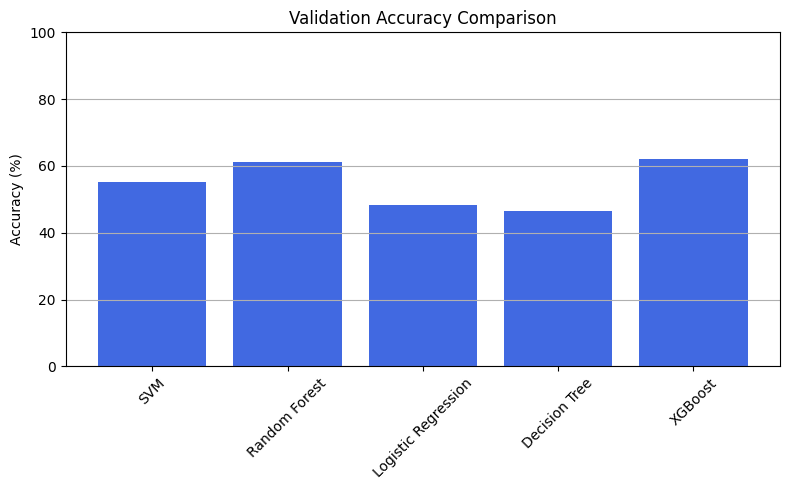

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), [v * 100 for v in accuracies.values()], color='royalblue')
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()